In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as scp
import itertools
import collections

# qPCR analysis


In [2]:
#Read in datasets from Jui (reshaped by me in excel)
qpcr_df = pd.read_csv('input_csvs/qPCR_short_long_CTs.csv')
qpcr_df.head()

,bio_replicate,hours,primer,tech_replicate,CT
0,1,0,18s,1,9.97
1,1,0,18s,2,10.08
2,1,0,18s,3,9.83
3,2,0,18s,1,10.22
4,2,0,18s,2,9.97


In [3]:
#Change time=0 to time=6 because that's when Jui actually took the first sample
qpcr_df.loc[qpcr_df['hours'].eq(0),'hours'] = 6

#NOTE
#Keeping 120 hours, but Jui said she saw cells lifting up from the plate and thinks the data will be low quality
#Don't include 120 hours in figures, just for exploratory graphics

#NOTE
#Keeping proximal1 primer, but it is low efficiency (see analysis/pericyte_timp3_experiment/qPCR_cDNA_dilution.ipynb)
#Only use for diagnostic graphs, not for figure graphs

qpcr_df

,bio_replicate,hours,primer,tech_replicate,CT
0,1,6,18s,1,9.97
1,1,6,18s,2,10.08
2,1,6,18s,3,9.83
3,2,6,18s,1,10.22
4,2,6,18s,2,9.97
...,...,...,...,...,...
415,3,120,distal2,2,23.56
416,3,120,distal2,3,23.08
417,4,120,distal2,1,23.45
418,4,120,distal2,2,23.22


## CT value trends for Timp3 vs. Housekeeping 

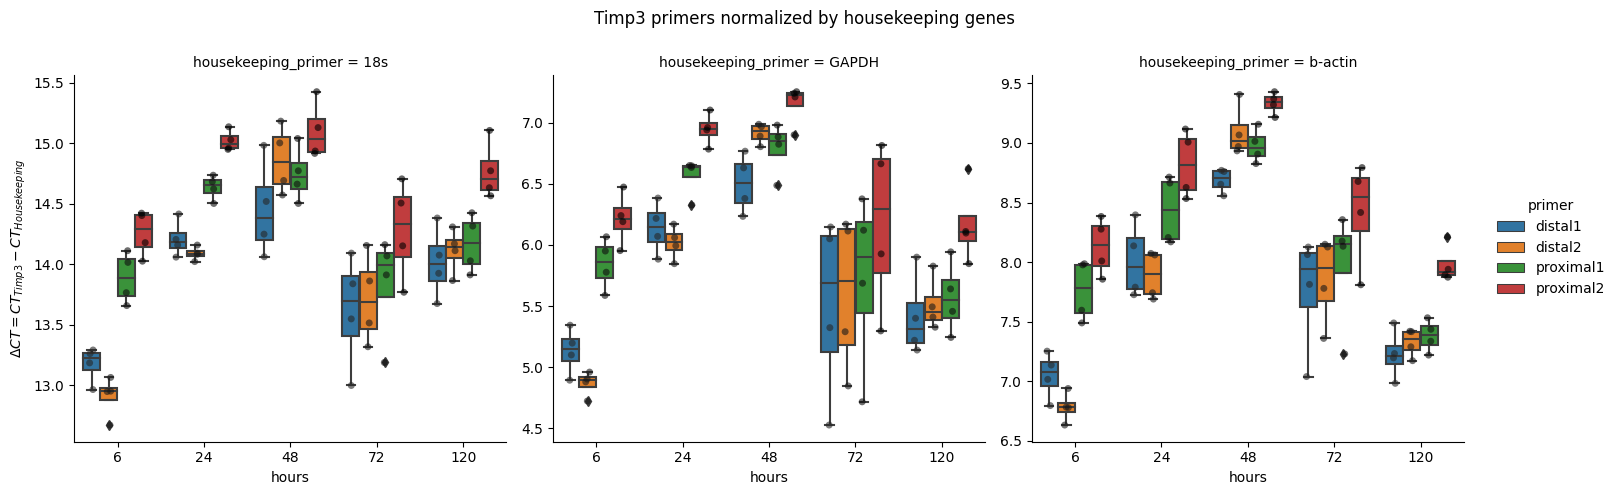

In [4]:
#CT trends of proximal and distal primers normalized by housekeeping genes
housekeeping_primers = ['18s','GAPDH','b-actin']
timp3_primers = ['proximal1','proximal2','distal1','distal2']
dCT_df = pd.DataFrame()

for housekeeping_primer in housekeeping_primers:
    #average housekeeping CTs over technical replicates
    housekeeping_CTs = (
        qpcr_df[qpcr_df['primer'].eq(housekeeping_primer)]
        .groupby(['bio_replicate','hours']).agg(
            housekeeping_mean_CT = ('CT','mean'),
            housekeeping_std_CT = ('CT','std'),
        )
        .reset_index()
        .assign(housekeeping_primer=housekeeping_primer)
    )

    #average Timp3 CTs over technical replicates
    timp3_CTs = (
        qpcr_df[qpcr_df['primer'].isin(timp3_primers)]
        .groupby(['primer','bio_replicate','hours']).agg(
            mean_CT = ('CT','mean'),
            std_CT = ('CT','std'),
        )
        .reset_index()
    )

    timp3_hk_cts = timp3_CTs.merge(housekeeping_CTs)
    timp3_hk_cts['dCT'] = timp3_hk_cts['mean_CT']-timp3_hk_cts['housekeeping_mean_CT']
    dCT_df = pd.concat((dCT_df,timp3_hk_cts))


#Plotting dCT values over time, not a publication-ready figure
dCT_df['${\Delta CT = CT_{Timp3}-CT_{Housekeeping}}$'] = dCT_df['dCT']
dCT_df['$2^{-\Delta CT}$'] = 2**(-dCT_df['dCT'])

g = sns.catplot(
    kind = 'box',
    x = 'hours',
    y = '${\Delta CT = CT_{Timp3}-CT_{Housekeeping}}$',
    hue = 'primer',
    col = 'housekeeping_primer',
    sharey = False,
    data = dCT_df,
)

g.map_dataframe(
    sns.stripplot,
    x = 'hours', 
    y = '${\Delta CT = CT_{Timp3}-CT_{Housekeeping}}$',
    hue = 'primer',
    palette='dark:black',
    alpha = 0.6,
    dodge=True,
)

plt.subplots_adjust(top=0.85)
plt.suptitle(f'Timp3 primers normalized by housekeeping genes')
plt.savefig(f'svgs/dCT_Timp3_primers_normalized_by_housekeeping_genes_boxplot.svg')
plt.show()
plt.close()

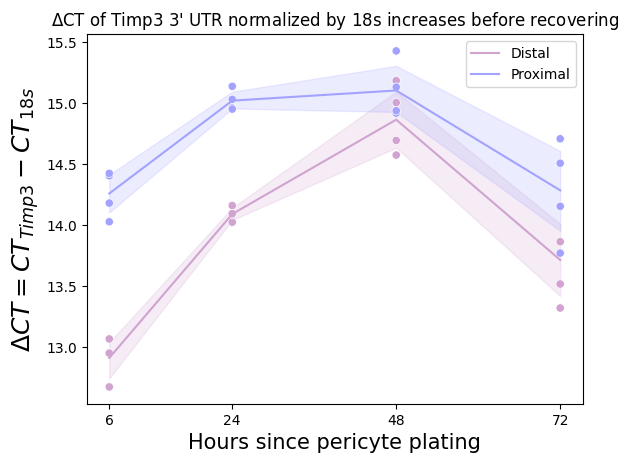

In [5]:
#PUBLICATION QUALITY dCT
#exlcuding proximal1 and timepoint-120
#arbitrary decision to select 18S as the houskeeping, and distal2 as the "long" primer
plot_df = dCT_df[
    dCT_df['primer'].isin({'proximal2','distal2'})
    & dCT_df['hours'].ne(120)
    & dCT_df['housekeeping_primer'].eq('18s')
].copy()

plot_df['Timp3 Primer Location'] = np.where(plot_df['primer'].str.startswith('proximal'),'Proximal','Distal')
palette = {'Distal':'#D0A3D0','Proximal':'#A3A3FF'}

ax = sns.lineplot(
    x = 'hours',
    y = '${\Delta CT = CT_{Timp3}-CT_{Housekeeping}}$',
    hue = 'Timp3 Primer Location',
    palette = palette,
    data = plot_df,
)
ax = sns.scatterplot(
    x = 'hours',
    y = '${\Delta CT = CT_{Timp3}-CT_{Housekeeping}}$',
    hue = 'Timp3 Primer Location',
    palette = palette,
    legend = False,
    data = plot_df,
    ax = ax,
)
plt.xticks(sorted(plot_df['hours'].unique()))
plt.xlabel('Hours since pericyte plating',fontsize=15)
plt.ylabel('${\Delta CT = CT_{Timp3}-CT_{18s}}$',fontsize=18)
plt.title("$\Delta$CT of Timp3 3' UTR normalized by 18s increases before recovering")
ax.get_legend().set_title(None)
plt.savefig('svgs/publication_quality/dCT_p2_d2_18s.svg')
plt.show()
plt.close()

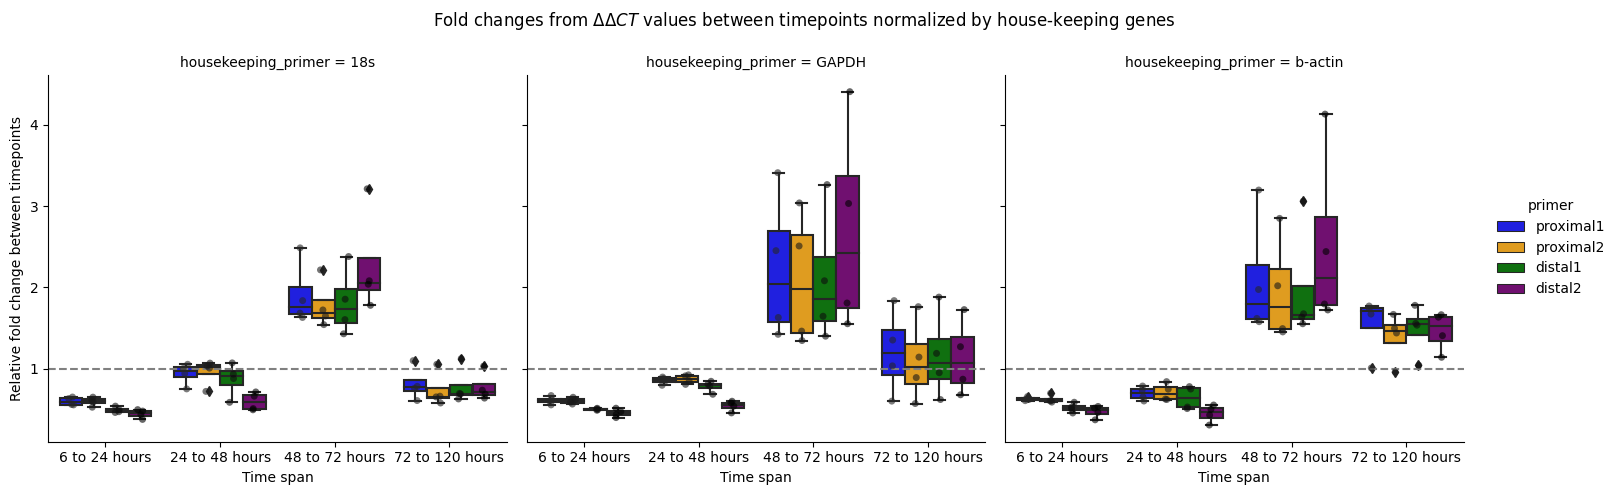

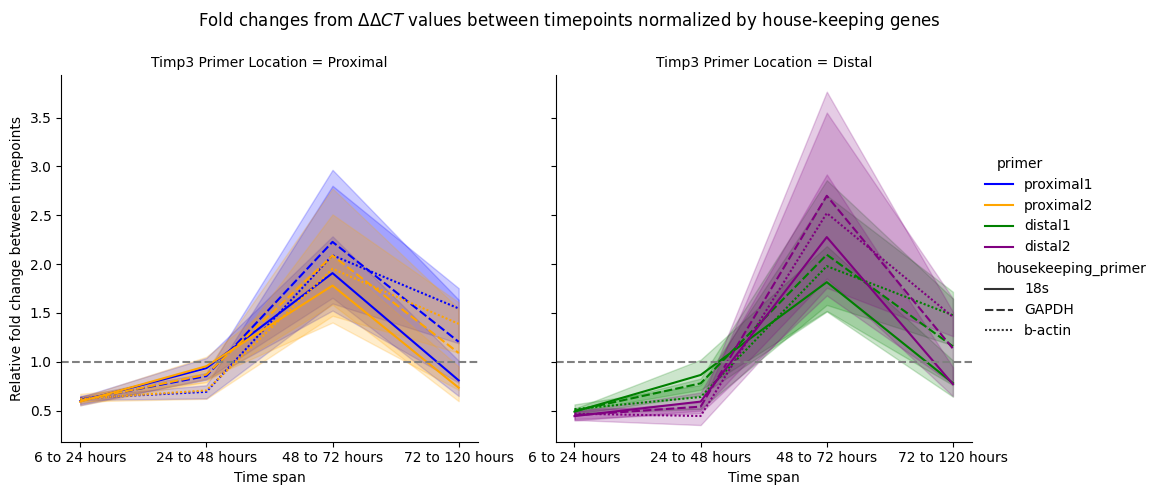

In [6]:
#Calculating delta-delta CT values between sequential timepoints
timepoint_pairs = [
    (6,24),
    (24,48),
    (48,72),
    (72,120),
]

ddCT_df = pd.DataFrame()
for t1,t2 in timepoint_pairs:
    ddCT_t1t2_df = (
        dCT_df[dCT_df['hours'].isin({t1,t2})].pivot(
            index = ['primer','bio_replicate','housekeeping_primer'],
            columns = 'hours',
            values = 'dCT',
        )
        .rename(columns={t1:'$\Delta CT_{t1}$',t2:'$\Delta CT_{t2}$'})
        .assign(t1=t1, t2=t2)
        .reset_index()
    )

    #note this is t1-t2 because larger ct values mean smaller amounts of Timp3
    #when t1 > t2, the ddCT > 0 which will be a positive fold increase
    ddCT_t1t2_df['$\Delta \Delta CT_{t1-t2}$'] = ddCT_t1t2_df['$\Delta CT_{t1}$']-ddCT_t1t2_df['$\Delta CT_{t2}$']
    ddCT_t1t2_df['fold_change'] = 2**ddCT_t1t2_df['$\Delta \Delta CT_{t1-t2}$']

    ddCT_df = pd.concat((ddCT_df,ddCT_t1t2_df))

ddCT_df['Time span'] = ddCT_df['t1'].astype(str)+' to '+ddCT_df['t2'].astype(str)+' hours'
ddCT_df['Timp3 Primer Location'] = np.where(ddCT_df['primer'].str.startswith('proximal'),'Proximal','Distal')
ddCT_df


#Making a boxplot
g = sns.catplot(
    x = 'Time span',
    y = 'fold_change',
    hue = 'primer',
    hue_order = ['proximal1','proximal2','distal1','distal2'],
    palette = ['blue','orange','green','purple'],
    col = 'housekeeping_primer',
    kind = 'box',
    data = ddCT_df,
)
g.map_dataframe(
    sns.stripplot,
    x = 'Time span',
    y = 'fold_change',
    hue = 'primer',
    hue_order = ['proximal1','proximal2','distal1','distal2'],
    palette='dark:black',
    alpha = 0.6,
    dodge=True,
)
plt.suptitle('Fold changes from $\Delta \Delta CT$ values between timepoints normalized by house-keeping genes')
plt.subplots_adjust(top=0.85)

for ax in g.axes.flatten():
    ax.set_ylabel('Relative fold change between timepoints')
    ax.axhline(1, linestyle='dashed', color='grey')

plt.savefig('svgs/ddCT_aggregate_boxplot.svg')
plt.show()
plt.close()

    
#Making a lineplot
#Aggregate figure to show that the house-keeping gene doesn't matter much
#and that the trends of both proximal and distal primers are the same
g = sns.relplot(
    x = 'Time span',
    y = 'fold_change',
    hue = 'primer',
    hue_order = ['proximal1','proximal2','distal1','distal2'],
    palette = ['blue','orange','green','purple'],
    col = 'Timp3 Primer Location',
    col_order = ['Proximal','Distal'],
    style = 'housekeeping_primer',
    kind = 'line',
    data = ddCT_df,
)
plt.suptitle('Fold changes from $\Delta \Delta CT$ values between timepoints normalized by house-keeping genes')
plt.subplots_adjust(top=0.85)

for ax in g.axes.flatten():
    ax.set_ylabel('Relative fold change between timepoints')
    ax.axhline(1, linestyle='dashed', color='grey')

plt.savefig('svgs/ddCT_aggregate_lineplot.svg')
plt.show()
plt.close()

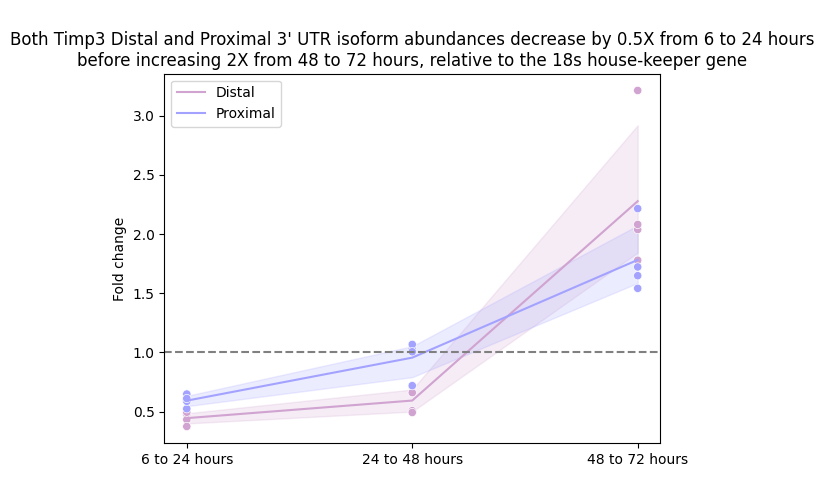

In [7]:
#PUBLICATION QUALITY ddCT plot
#exlcuding proximal1 and timepoint-120
#arbitrary decision to select 18S as the houskeeping, and distal2 as the "long" primer

#Calculating delta-delta CT values between sequential timepoints
timepoint_pairs = [
    (6,24),
    (24,48),
    (48,72),
]

ddCT_df = pd.DataFrame()
for t1,t2 in timepoint_pairs:
    ddCT_t1t2_df = (
        dCT_df[
            dCT_df['hours'].isin({t1,t2})
            & dCT_df['primer'].isin({'proximal2','distal2'})
            & dCT_df['housekeeping_primer'].eq('18s')
        ].pivot(
            index = ['primer','bio_replicate','housekeeping_primer'],
            columns = 'hours',
            values = 'dCT',
        )
        .rename(columns={t1:'$\Delta CT_{t1}$',t2:'$\Delta CT_{t2}$'})
        .assign(t1=t1, t2=t2)
        .reset_index()
    )

    #note this is t1-t2 because larger ct values mean smaller amounts of Timp3
    #when t1 > t2, the ddCT > 0 which will be a positive fold increase for t1 --> t2
    ddCT_t1t2_df['$\Delta \Delta CT_{t1-t2}$'] = ddCT_t1t2_df['$\Delta CT_{t1}$']-ddCT_t1t2_df['$\Delta CT_{t2}$']
    ddCT_t1t2_df['fold_change'] = 2**ddCT_t1t2_df['$\Delta \Delta CT_{t1-t2}$']

    ddCT_df = pd.concat((ddCT_df,ddCT_t1t2_df))

ddCT_df['Time span'] = ddCT_df['t1'].astype(str)+' to '+ddCT_df['t2'].astype(str)+' hours'
ddCT_df['Timp3 Primer Location'] = np.where(ddCT_df['primer'].str.startswith('proximal'),'Proximal','Distal')

ax = sns.lineplot(
    x = 'Time span',
    y = 'fold_change',
    hue = 'Timp3 Primer Location',
    palette = {'Distal':'#D0A3D0','Proximal':'#A3A3FF'},
    data = ddCT_df,
)
sns.scatterplot(
    x = 'Time span',
    y = 'fold_change',
    hue = 'Timp3 Primer Location',
    palette = {'Distal':'#D0A3D0','Proximal':'#A3A3FF'},
    legend = False,
    ax = ax,
    data = ddCT_df,
)

#remove the legend title (https://stackoverflow.com/questions/51579215/remove-seaborn-lineplot-legend-title)
ax.get_legend().set_title(None)
plt.xlabel('')
plt.title("""
Both Timp3 Distal and Proximal 3' UTR isoform abundances decrease by 0.5X from 6 to 24 hours
before increasing 2X from 48 to 72 hours, relative to the 18s house-keeper gene""")
plt.ylabel('Fold change')
plt.axhline(1, color='grey', linestyle='dashed')
plt.savefig('svgs/publication_quality/ddCT_p2_d2_18s.svg')
plt.show()
plt.close()

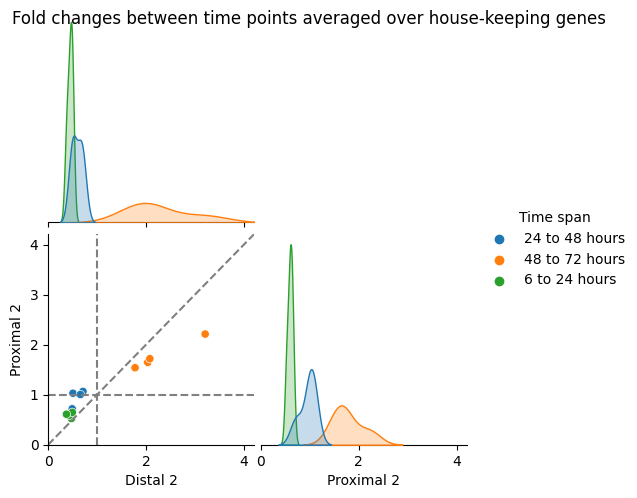

In [8]:
#Not sure why I made this plot
#What is it showing?
#(I'll keep it for now)

primer_pairs = [
    ('distal1','proximal1'),
    ('distal1','proximal2'),
    ('distal2','proximal1'),
    ('distal2','proximal2'),
]

#averaging ddCT over house-keeping primer
fold_change_piv_df = ddCT_df.pivot_table(
    index = ['Time span','bio_replicate'],
    columns = 'primer',
    values = 'fold_change',
    aggfunc = 'mean',
)

min_fold_change = 0
max_fold_change = fold_change_piv_df.max().max()+1

fold_change_piv_df = fold_change_piv_df.reset_index()

#plotting
g = sns.pairplot(
    fold_change_piv_df.set_index('bio_replicate'),
    corner = True,
    hue = 'Time span',
)

pretty_xy_names = {
    'distal1':'Distal 1',
    'distal2':'Distal 2',
    'proximal1':'Proximal 1',
    'proximal2':'Proximal 2',
}

for i,row_axs in enumerate(g.axes):
    for j,ax in enumerate(row_axs):
        #plotting 'corner=True' results in null axes
        if not ax:
            continue
        
        #make the x and y labels nicer looking
        ax.set_xlabel(pretty_xy_names.get(ax.get_xlabel()))
        ax.set_ylabel(pretty_xy_names.get(ax.get_ylabel()))
        
        #adjust xlim for all subplots, even diagonal
        ax.set_xlim(min_fold_change, max_fold_change)
        
        #don't add y=x line for the diagonal entries
        if i == j:
            continue
            
        ax.axline((0, 0), slope=1, linestyle='dashed', color='grey')
        ax.axhline(1, linestyle='dashed', color='grey')
        ax.axvline(1, linestyle='dashed', color='grey')
        
        #only adjust ylim for off-diagonals
        ax.set_ylim(min_fold_change, max_fold_change)
        
plt.suptitle('Fold changes between time points averaged over house-keeping genes')
plt.savefig('svgs/pairplot_foldchange_qPCR.svg')
plt.show()
plt.close()

## CT Timp3 proximal vs. distal

In [9]:
#Calculating 2^-(CT_total-CT_long) per technical replicate
#to check if the value is ever less than 1 which is unexpected

pd_pairs = itertools.product(['proximal1', 'proximal2'],['distal1', 'distal2'])
piv_dfs = []
for p,d in pd_pairs:
    pd_df = qpcr_df[qpcr_df['primer'].isin({p,d})]
    
    #create a pivoted df w/ the following columns:
    #  bio_replicate  tech_replicate  hours  dist_CT   prox_CT  prox_primer   dist_primer 
    #              1               1      0    22.84     23.69    proximal1        distal1
    #              1               1     24    23.42     24.29    proximal1        distal1
    #              1               1     48    23.71     24.02    proximal1        distal1
    #              1               1     72    22.23     22.46    proximal1        distal1
    #              1               1    120    22.85     23.23    proximal1        distal1
    piv_df = (
        pd_df.pivot(
            index=['bio_replicate','tech_replicate','hours'],
            columns='primer',
            values='CT',
        )
        .reset_index()
        .rename(columns={p:'prox_CT',d:'dist_CT'})
        .assign(prox_primer=p, dist_primer=d)
    )
    
    piv_dfs.append(piv_df)
    

bio_tech_rep_cts = pd.concat(piv_dfs)

#Note this is the ratio of distal to proximal since it will be 2X if dist_CT = prox_CT-1
#(the subtraction order is reversed than expected since larger CTs represent smaller amounts of template)
bio_tech_rep_cts['Distal/Proximal'] = 2**(bio_tech_rep_cts.prox_CT-bio_tech_rep_cts.dist_CT)

display(bio_tech_rep_cts)

#expecting Distal/Proximal to be < 1 since proximal should count BOTH long and short isoforms
#however, we see that for the vast majority of replicates, Distal/Proximal is NOT < 1, which is strange
bio_tech_rep_cts['Distal/Proximal'].lt(1).value_counts()

primer,bio_replicate,tech_replicate,hours,dist_CT,prox_CT,prox_primer,dist_primer,Distal/Proximal
0,1,1,6,22.84,23.69,proximal1,distal1,1.802501
1,1,1,24,23.42,24.29,proximal1,distal1,1.827663
2,1,1,48,23.71,24.02,proximal1,distal1,1.239708
3,1,1,72,22.23,22.46,proximal1,distal1,1.172835
4,1,1,120,22.85,23.23,proximal1,distal1,1.301342
...,...,...,...,...,...,...,...,...
55,4,3,6,22.43,24.34,proximal2,distal2,3.758091
56,4,3,24,23.69,24.91,proximal2,distal2,2.329467
57,4,3,48,24.24,24.67,proximal2,distal2,1.347234
58,4,3,72,23.45,23.87,proximal2,distal2,1.337928


False    222
True      18
Name: Distal/Proximal, dtype: int64

In [10]:
#each pair of prox/dist primers have similarly 'bad' values where Dist/Prox > 1
bio_tech_rep_cts.groupby(['prox_primer','dist_primer'])['Distal/Proximal'].apply(lambda v: v.lt(1).value_counts())

prox_primer  dist_primer       
proximal1    distal1      False    56
                          True      4
             distal2      False    47
                          True     13
proximal2    distal1      False    60
             distal2      False    59
                          True      1
Name: Distal/Proximal, dtype: int64

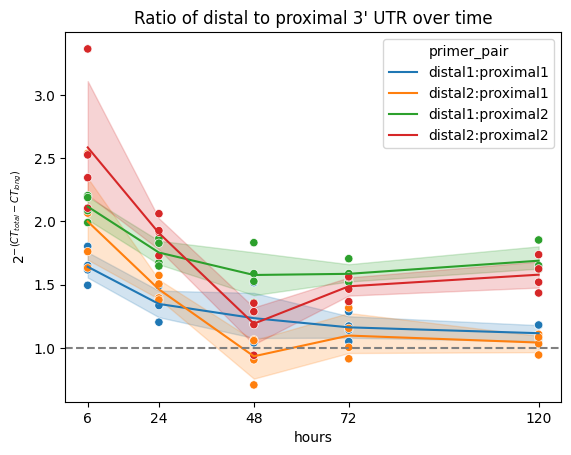

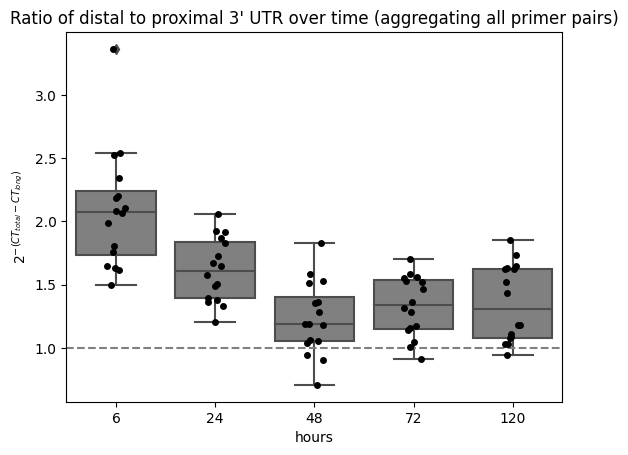

In [11]:
#Exploratory graphs, NOT publication quality

#Average the qPCR technical replicates to get mean and std CT per primer, replicate, hour
agg_cts = qpcr_df.groupby(['bio_replicate','hours','primer']).agg(
    mean_CT = ('CT','mean'),
    std_CT = ('CT','std'),
).reset_index()


#calculate ratio of distal to proximal (partial to total) for each timepoint
#this is 2**(CT_prox-CT_dist)
#because when CT_prox = CT_dist-1 then ratio will be 1/2
pairwise_CT = pd.DataFrame()

for s,l in itertools.product(['proximal1', 'proximal2'],['distal1', 'distal2']):
    sl_df = agg_cts[agg_cts['primer'].isin({s,l})]
    sl_df = sl_df.pivot(
        index=['bio_replicate','hours'],
        columns='primer',
        values='mean_CT',
    ).reset_index()
    
    sl_df['dCT'] = 2**(sl_df[s]-sl_df[l])
    sl_df['primer_pair'] = f'{l}:{s}'
    sl_df = sl_df.rename(columns={s:'proximal_primer',l:'distal_primer'})

    pairwise_CT = pd.concat((pairwise_CT,sl_df))
    
    
#Plot the dCT for each pair of primers
sns.lineplot(
    x = 'hours',
    y = 'dCT',
    hue = 'primer_pair',
    data = pairwise_CT,
)
sns.scatterplot(
    x = 'hours',
    y = 'dCT',
    hue = 'primer_pair',
    legend = False,
    data = pairwise_CT,
)
plt.axhline(y=1, linestyle='dashed', color='grey')
plt.title("Ratio of distal to proximal 3' UTR over time")
plt.xticks(sorted(pairwise_CT['hours'].unique()))
plt.ylabel('$2^{-(CT_{total}-CT_{long})}$')
plt.savefig('svgs/dCT_total_vs_long_per_primer_pair.svg')
plt.show()
plt.close()


#Plot the dCT averaged over all primer pairs
sns.boxplot(
    x = 'hours',
    y = 'dCT',
    color = 'grey',
    data = pairwise_CT,
)
sns.stripplot(
    x = 'hours',
    y = 'dCT',
    color = 'black',
    data = pairwise_CT,
)
plt.axhline(y=1, linestyle='dashed', color='grey')
plt.ylabel('$2^{-(CT_{total}-CT_{long})}$')
plt.title("Ratio of distal to proximal 3' UTR over time (aggregating all primer pairs)")
plt.savefig('svgs/dCT_total_vs_long.svg')
plt.show()
plt.close()

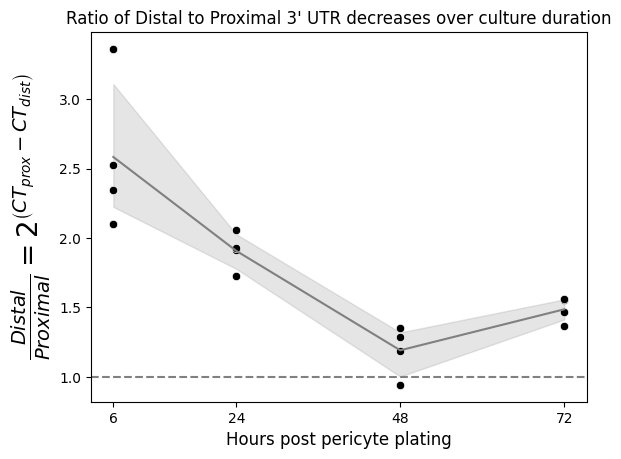

In [12]:
#Publication quality distal/proximal ratio over time
#limiting to prox2/dist2/18s
#ignoring t=120

plot_df = pairwise_CT[
    pairwise_CT['hours'].ne(120)
    & pairwise_CT['primer_pair'].eq('distal2:proximal2')
].copy()

#Plot the dCT for each pair of primers
sns.lineplot(
    x = 'hours',
    y = 'dCT',
    color = 'grey',
    data = plot_df,
)
sns.scatterplot(
    x = 'hours',
    y = 'dCT',
    color = 'black',
    legend = False,
    data = plot_df,
)

plt.axhline(y=1, linestyle='dashed', color='grey')
plt.title("Ratio of Distal to Proximal 3' UTR decreases over culture duration")
plt.xticks(sorted(plot_df['hours'].unique()))
plt.xlabel('Hours post pericyte plating',fontsize=12)
plt.ylabel('$\\frac{Distal}{Proximal} = 2^{\\left(CT_{prox}-CT_{dist}\\right)}$',fontsize=20)
plt.savefig('svgs/publication_quality/dCT_total_vs_long_p2_d2.svg')
plt.show()
plt.close()

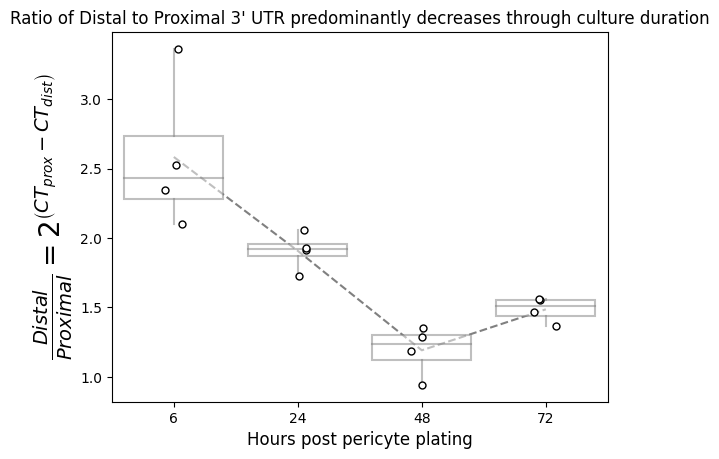

In [13]:
#Alternative to the lineplot of Distal/Proximal with boxplots
#Publication quality distal/proximal ratio over time
#limiting to prox2/dist2/18s
#ignoring t=120

plot_df = pairwise_CT[
    pairwise_CT['hours'].ne(120)
    & pairwise_CT['primer_pair'].eq('distal2:proximal2')
].copy()

#Plot the dCT for each pair of primers
sns.boxplot(
    x = 'hours',
    y = 'dCT',
    color = 'grey',
    boxprops = {'facecolor':'white','edgecolor':'grey','alpha':0.5},
    medianprops = {'color':'grey','alpha':0.5},
    capprops = {'color':'none'},
    whiskerprops = {'color':'grey','alpha':0.5},
    data = plot_df,
)
sns.stripplot(
    x = 'hours',
    y = 'dCT',
    marker='o',
    color = 'white',
    edgecolor='black', 
    linewidth=1,
    legend = False,
    data = plot_df,
)
plt.plot(
    plot_df.groupby('hours')['dCT'].mean().values,
    color='grey',
    linestyle='dashed',
    zorder=-1,
)

plt.title("Ratio of Distal to Proximal 3' UTR predominantly decreases through culture duration")
plt.xlabel('Hours post pericyte plating',fontsize=12)
plt.ylabel('$\\frac{Distal}{Proximal} = 2^{\\left(CT_{prox}-CT_{dist}\\right)}$',fontsize=20)
plt.savefig('svgs/publication_quality/dCT_total_vs_long_p2_d2_boxplot.svg')
plt.show()
plt.close()

In [14]:
#Finding which shifts in time are significantly different by ttest
#from the above chosen conditions
totest_df = plot_df.copy()

#(24 --> 48) is the only statistically statistically significant time-step
data = {
    'time1':[],
    'time2':[],
    't':[],
    'p':[],   
}
time_pairs = [
    (6,24),
    (24,48),
    (48,72),
]

for t1,t2 in time_pairs:
    x1 = totest_df[totest_df['hours'].eq(t1)]['dCT']
    x2 = totest_df[totest_df['hours'].eq(t2)]['dCT']
    t,p = scp.stats.ttest_ind(x1,x2)
    data['time1'].append(t1)
    data['time2'].append(t2)
    data['t'].append(t)
    data['p'].append(p)

ttest_df = pd.DataFrame(data)
ttest_df['significant'] = ttest_df['p'].le(0.05/len(time_pairs)) #Bonferroni correction
ttest_df

,time1,time2,t,p,significant
0,6,24,2.400869,0.053232,False
1,24,48,6.334988,0.000724,True
2,48,72,-2.916786,0.026743,False


# Protein concentration analysis


In [15]:
conc_df = pd.read_csv('input_csvs/timp3_protein_concentrations.csv')

#constants used in analysis
culture_volume = 2 #2 mLs
timp3_halflife = 15 #~15 hours: https://www.nature.com/articles/s41419-021-04192-8
frac_timp3_24_hours = 0.5**(24/timp3_halflife) #fraction of original Timp3 left after 24 hours
timp3_mw = 3e4 #kDa https://www.novusbio.com/products/recombinant-human-timp-3-protein-cf_973-tm (30,000 g/mol)

#time = 0 is really t=6 hours, so update it
conc_df.loc[conc_df['hours'].eq(0),'hours'] = 6
conc_df

,hours,replicate,BCA (ng/mL),cells,timp3 (ng/mL)
0,6,1,5497.8,120000.0,0.0139
1,6,2,4919.9,120000.0,0.0269
2,6,3,5151.1,120000.0,0.0659
3,6,4,4919.9,120000.0,0.0225
4,24,1,5547.3,159000.0,0.5555
5,24,2,5365.7,152000.0,0.6464
6,24,3,5695.9,149000.0,0.7244
7,24,4,5745.4,176000.0,0.6118
8,48,1,5728.9,249000.0,1.7080
9,48,2,5464.8,209000.0,1.7166


In [16]:
#remove the 120 hour timepoint, Jui said the cells were dying and this is her recommendation
conc_df = conc_df[conc_df['hours'].lt(120)].copy()

#substract min timp3 concentration from each replicate (always t=6)
conc_df['timp3 (ng/mL)'] = conc_df.groupby('replicate')['timp3 (ng/mL)'].transform(
    lambda timp3s: timp3s-min(timp3s)
)

#Convert the concentrations into ng's using the culture volume
conc_df['BCA (ng/mL)'] *= culture_volume
conc_df['timp3 (ng/mL)'] *= culture_volume

conc_df = conc_df.rename(columns={'BCA (ng/mL)':'BCA (ng)','timp3 (ng/mL)':'Timp3 (ng)'})
conc_df

,hours,replicate,BCA (ng),cells,Timp3 (ng)
0,6,1,10995.6,120000.0,0.0000
1,6,2,9839.8,120000.0,0.0000
2,6,3,10302.2,120000.0,0.0000
3,6,4,9839.8,120000.0,0.0000
4,24,1,11094.6,159000.0,1.0832
5,24,2,10731.4,152000.0,1.2390
6,24,3,11391.8,149000.0,1.3170
7,24,4,11490.8,176000.0,1.1786
8,48,1,11457.8,249000.0,3.3882
9,48,2,10929.6,209000.0,3.3794


,replicate,t1,t2,starting Timp3 (ng),ending Timp3 (ng),degraded Timp3 (ng),created Timp3 (ng),starting cells,ending cells,Time span,Secreted Timp3 ng per cell per hour,Secreted Timp3 molecules per cell per hour
0,1,6,24,0.0000,1.0832,0.000000e+00,1.0832,120000.0,159000.0,6-hrs to 24-hrs,5.014815e-07,277.583019
1,1,24,48,1.0832,3.3882,1.166586e-14,2.3050,159000.0,249000.0,24-hrs to 48-hrs,6.040356e-07,334.349407
2,1,48,72,3.3882,7.4436,6.593338e-21,4.0554,249000.0,201000.0,48-hrs to 72-hrs,6.786145e-07,375.630719
3,2,6,24,0.0000,1.2390,0.000000e+00,1.2390,120000.0,152000.0,6-hrs to 24-hrs,5.736111e-07,317.508641
4,2,24,48,1.2390,3.3794,1.334380e-14,2.1404,152000.0,209000.0,24-hrs to 48-hrs,5.867325e-07,324.771646
5,2,48,72,3.3794,5.4072,6.576213e-21,2.0278,209000.0,230000.0,48-hrs to 72-hrs,4.042663e-07,223.771918
6,3,6,24,0.0000,1.3170,0.000000e+00,1.3170,120000.0,149000.0,6-hrs to 24-hrs,6.097222e-07,337.497079
7,3,24,48,1.3170,4.2286,1.418384e-14,2.9116,149000.0,151000.0,24-hrs to 48-hrs,8.142058e-07,450.684057
8,3,48,72,4.2286,8.6134,8.228732e-21,4.3848,151000.0,182000.0,48-hrs to 72-hrs,1.209934e-06,669.729755
9,4,6,24,0.0000,1.1786,0.000000e+00,1.1786,120000.0,176000.0,6-hrs to 24-hrs,5.456481e-07,302.030415


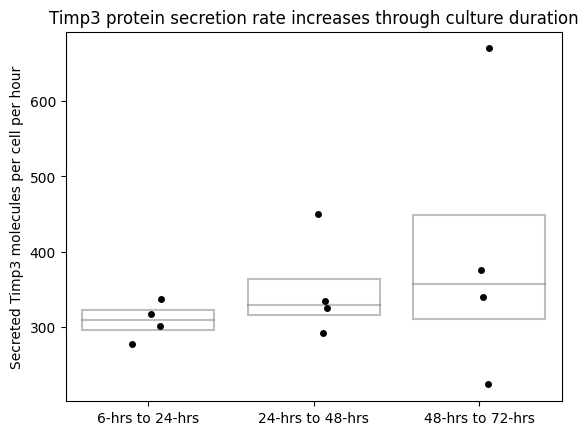

In [17]:
#Group by replicate and convert Timp3 protein values to time-spans
time_spans = [(6,24),(24,48),(48,72)]
data = collections.defaultdict(list)

for r,g in conc_df.groupby('replicate'):
    g = g.set_index('hours')
    for t1,t2 in time_spans:
        frac_degraded = 0.5**(t2-t1/timp3_halflife)
        starting_timp3 = g.loc[t1]['Timp3 (ng)']
        ending_timp3 = g.loc[t2]['Timp3 (ng)']
        degraded_timp3 = g.loc[t1]['Timp3 (ng)']*frac_degraded
        
        data['replicate'].append(r)
        data['t1'].append(t1)
        data['t2'].append(t2)
        data['starting Timp3 (ng)'].append(starting_timp3)
        data['ending Timp3 (ng)'].append(ending_timp3)
        data['degraded Timp3 (ng)'].append(degraded_timp3)
        data['created Timp3 (ng)'].append(ending_timp3-(starting_timp3-degraded_timp3))
        data['starting cells'].append(g.loc[t1]['cells'])
        data['ending cells'].append(g.loc[t2]['cells'])


time_span_conc_df = pd.DataFrame(data)
time_span_conc_df['Time span'] = (
    time_span_conc_df['t1'].astype(str)+'-hrs to '
    +time_span_conc_df['t2'].astype(str)+'-hrs'
)

time_span_conc_df['Secreted Timp3 ng per cell per hour'] = (
    time_span_conc_df['created Timp3 (ng)'].divide(
        time_span_conc_df['starting cells']
    ).divide(
        time_span_conc_df['t2']-time_span_conc_df['t1']
    )
)

#Convert from ng's of Timp3 to molecules of Timp3
#(X Timp3 ng)(1g/1e9ng)(1mol/3e4g)(6.022e23 molecules / 1 mol) = (x/6.022)e10 molecules
time_span_conc_df['Secreted Timp3 molecules per cell per hour'] = (
    time_span_conc_df['Secreted Timp3 ng per cell per hour'].div(6.022*3).multiply(1e10)
)

display(time_span_conc_df)


#Make a simple boxplot
sns.boxplot(
    x = 'Time span',
    y = 'Secreted Timp3 molecules per cell per hour',
    color = 'grey',
    boxprops = {'facecolor':'white','edgecolor':'grey','alpha':0.5},
    medianprops = {'color':'grey','alpha':0.5},
    capprops = {'color':'none'},
    whiskerprops = {'color':'none'},
    fliersize = 0,
    data = time_span_conc_df,
)

sns.stripplot(
    x = 'Time span',
    y = 'Secreted Timp3 molecules per cell per hour',
    color = 'black',
    data = time_span_conc_df,
)
plt.xlabel('')
plt.title('Timp3 protein secretion rate increases through culture duration')
plt.savefig('svgs/publication_quality/secreted_timp3_molecules_per_cell_per_hour.svg')
plt.show()
plt.close()

In [18]:
#ttests between all pairs of times for differences in Timp3 proteins secreted
#neither 6-24 vs 24-48 or 24-48 vs 48-72 have significant rate changes

totest_df = time_span_conc_df.copy()

data = {
    'time1':[],
    'time2':[],
    't':[],
    'p':[],   
}
time_pairs = [
    ('6-hrs to 24-hrs','24-hrs to 48-hrs'),
    ('24-hrs to 48-hrs','48-hrs to 72-hrs'),
]

for t1,t2 in time_pairs:
    x1 = totest_df[totest_df['Time span'].eq(t1)]['Secreted Timp3 molecules per cell per hour']
    x2 = totest_df[totest_df['Time span'].eq(t2)]['Secreted Timp3 molecules per cell per hour']
    t,p = scp.stats.ttest_ind(x1,x2)
    data['time1'].append(t1)
    data['time2'].append(t2)
    data['t'].append(t)
    data['p'].append(p)

ttest_df = pd.DataFrame(data)
ttest_df['significant'] = ttest_df['p'].le(0.05/len(time_pairs)) #Bonferroni correction
ttest_df

,time1,time2,t,p,significant
0,6-hrs to 24-hrs,24-hrs to 48-hrs,-1.132198,0.300761,False
1,24-hrs to 48-hrs,48-hrs to 72-hrs,-0.512192,0.626817,False


# Combining isoform qPCR and Timp3 protein ELISA data

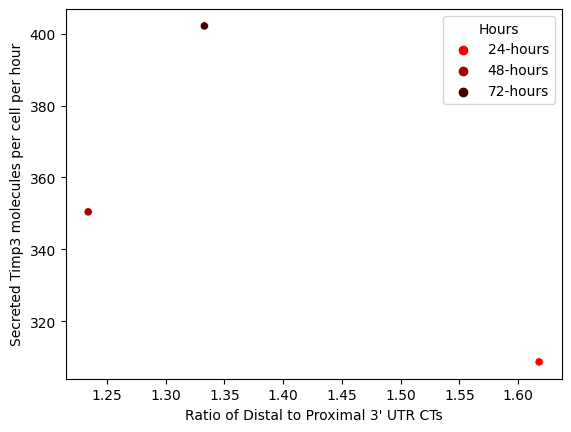

In [19]:
qpcr_series = pairwise_CT.groupby('hours')['dCT'].mean()
conc_series = time_span_conc_df.groupby('t2')['Secreted Timp3 molecules per cell per hour'].mean()

joint_df = pd.concat((qpcr_series,conc_series),axis=1).reset_index()
joint_df['Hours'] = joint_df['index'].astype(str)+'-hours'

sns.scatterplot(
    x = "dCT",
    y = 'Secreted Timp3 molecules per cell per hour',
    hue = 'Hours',
    palette = ['#ff0000','#aa0000','#440000'],
    data = joint_df.dropna(),
)
plt.xlabel("Ratio of Distal to Proximal 3' UTR CTs")
plt.savefig('svgs/secretion_vs_CT.svg')
plt.show()
plt.close()